<a href="https://colab.research.google.com/github/Vikhyat-1820/image-captioning/blob/master/image_captioning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
import string
from keras.utils import to_categorical
from keras.layers import Input,Dropout,Dense,LSTM,Embedding
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
import os
import pickle
from keras.preprocessing.text import Tokenizer

In [33]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
def extract_text(filename):
  description=dict()
  doc=open(filename,'r')
  text=doc.read()
  table = str.maketrans('', '', string.punctuation)
  for line in text.split('\n'):
    word=line.split()
    if len(word)<2:
      continue
    idx=word[0]
    idx=idx.split('.')[0]
    data=word[1:]
    data = [w.translate(table) for w in data]
    data=[d for d in data if len(d)>1]
    data = [d for d in data if d.isalpha()]
    desc='startseq ' +  ' '.join(data) + ' endseq'
    if idx not in description:
      description[idx]=list()
    description[idx].append(desc)
  return description

In [0]:
description=extract_text('/content/drive/My Drive/Flickr8k.token.txt')

In [36]:
description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [37]:
vggmodel=VGG16()
vggmodel.layers.pop()
vggmodel=Model(inputs=vggmodel.inputs,outputs=vggmodel.layers[-1].output)
print(vggmodel.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
def feature_extractor(filename,vggmodel):
  img=image.load_img(filename,target_size=(224,224))
  img=image.img_to_array(img)
  img=img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
  img=preprocess_input(img)
  features=vggmodel.predict(img)
  return features

def image_feature(filename,vggmodel):
  features=dict()
  for img in os.listdir(filename):
    imgname=filename + '/' + img
    img=img.split('.')[0]

    features[img]=feature_extractor(imgname,vggmodel)
  return features
    


In [0]:
image_features=image_feature('/content/drive/My Drive/Flicker8k_Dataset',vggmodel)

In [40]:
len(image_features)

8093

In [0]:
pickle.dump(image_features,open('image_features_VGG.pkl','wb'))

In [0]:
def trainimage_and_description(description,image_features,trainfilename,maxcount):
  count=0
  trainimage={}
  traindescription={}
  text=open(trainfilename,'r').read()
  text=text.split()
  for k in text:
    k=k.split('.')[0]
    if count>maxcount:
      break
    if k in image_features.keys():
      count+=1
      trainimage[k]=image_features[k]
      traindescription[k]=description[k]
  return trainimage,traindescription

def valimage_and_description(description,image_features,valfilename,maxcount):
  valimage={}
  valdescription={}
  count=0
  text=open(valfilename,'r').read()
  text=text.split()
  for k in text:
    if count>maxcount:
      break
    k=k.split('.')[0]
    if k in image_features.keys():
      count+=1
      valimage[k]=image_features[k]
      valdescription[k]=description[k]
  return valimage,valdescription


In [0]:
#creating validation and train image
valimage,valdescription=valimage_and_description(description,image_features,'/content/drive/My Drive/Flickr_8k.testImages.txt',300)
trainimage,traindescription=trainimage_and_description(description,image_features,'/content/drive/My Drive/Flickr_8k.trainImages.txt',1200)

In [0]:
def to_lines(description):
  lines=list()
  for key in description.keys():
    [lines.append(d) for d in description[key]]
  return lines

def create_tokenizer(description):
  lines=to_lines(description)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

def maxlength(description):
  lines=to_lines(description)
  return max(len(d.split()) for d in lines) 

In [0]:
max_len=maxlength(description)
tokenizer=create_tokenizer(description)
vocab_size=len(tokenizer.word_index)+1
def preprocess_dataset(description,image_features,max_len,tokenizer,vocab_size):
  count=0
  X1,X2,Y=list(),list(),list()
  for key,desc in description.items():
    for desc in description[key]:
      seq = tokenizer.texts_to_sequences([desc])[0]
      for i in range(1,len(seq)):
        inp=seq[:i]
        op=seq[i]
        inp=pad_sequences([inp],maxlen=max_len)[0]
        op=to_categorical([op],num_classes=vocab_size)[0]
        if key in image_features.keys():
          X1.append(image_features[key][0])
          X2.append(inp)
          Y.append(op)
    count+=1
  return np.array(X1),np.array(X2),np.array(Y)


In [0]:
traininp1,traininp2,trainoup=preprocess_dataset(traindescription,trainimage,max_len,tokenizer,vocab_size)

In [0]:
valinp1,valinp2,valoup=preprocess_dataset(valdescription,valimage,max_len,tokenizer,vocab_size)

In [59]:
print(traininp1.shape,traininp2.shape,trainoup.shape)

(61297, 4096) (61297, 34) (61297, 8766)


In [60]:
print(valinp1.shape,valinp2.shape,valoup.shape)

(15494, 4096) (15494, 34) (15494, 8766)


In [0]:
def define_model(max_length,vocab_size):
	inp1 = Input(shape=(4096,))
	im1 = Dropout(0.5)(inp1)
	im2 = Dense(256, activation='relu')(im1)
	inp2 = Input(shape=(max_length,))
	tx1 = Embedding(vocab_size, 256, mask_zero=True)(inp2)
	tx2 = Dropout(0.5)(tx1)
	tx3 = LSTM(256)(tx2)
	comb1 = add([im2, tx3])
	comb2 = Dense(256, activation='relu')(comb1)
	oups = Dense(vocab_size, activation='softmax')(comb2)
	model = Model(inputs=[inp1, inp2], outputs=oups)
	model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
	print(model.summary())
	return model

In [62]:
model = define_model(max_len,vocab_size)
model.fit([traininp1, traininp2], trainoup, epochs=40,validation_data=([valinp1,valinp2],valoup))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      2244096     input_6[0][0]                    
______________________________________________________________________________

KeyboardInterrupt: ignored

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
def int_to_word(integer,tokenizer):
  for word, index in tokenizer.word_index.items():
    #print(index)
    if index == integer:
      return word
  return None

In [0]:
def generate_desc(photo,tokenizer,max_length,vocab_size):
  text='startseq'
  for i in range(max_length):
    seq=tokenizer.texts_to_sequences([text])[0]
    seq=pad_sequences([seq],maxlen=max_length)
    yhat=model.predict([photo,seq])
    yhat=np.argmax(yhat)
    #print(yhat)
    word=int_to_word(yhat,tokenizer)
    text=text + ' ' + word
    if word is None:
      break
    if word=='endseq':
      break
    
  return text

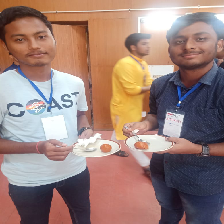

In [79]:
img=image.load_img('/content/drive/My Drive/IMG-20191013-WA0004.jpg',target_size=(224,224))
img

In [0]:
feature=feature_extractor('/content/drive/My Drive/IMG-20191013-WA0004.jpg',vggmodel)

In [0]:
text=generate_desc(feature,tokenizer,max_len,vocab_size)

In [82]:
text

'startseq two men are walking towards the camera endseq'